In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import os
import random
import cv2
from keras.layers.core import Dense
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from PIL import Image
from scipy.linalg import svd
from numpy import linalg as la
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
! pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.9 MB/s eta 0:00:00


In [4]:
import timm
from fastai.vision.all import *

In [5]:
trn_path = r'/content/drive/My Drive/paddy/train_images'
files = get_image_files(trn_path)

(480, 640)


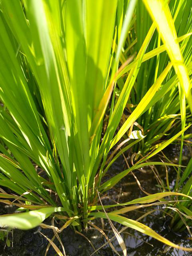

In [8]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(256)

In [9]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(480, 640)    10413
(640, 480)        4
dtype: int64

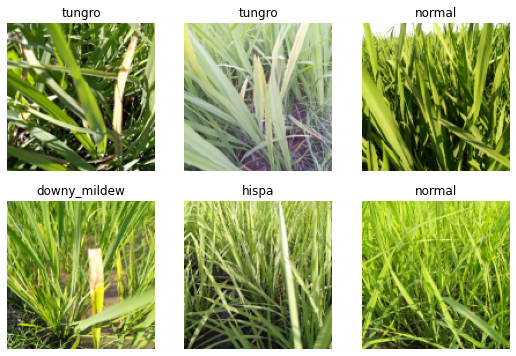

In [10]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=6)

In [11]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26d-69e92c46.pth" to /root/.cache/torch/hub/checkpoints/resnet26d-69e92c46.pth


SuggestedLRs(valley=0.0006918309954926372, slide=0.001737800776027143)

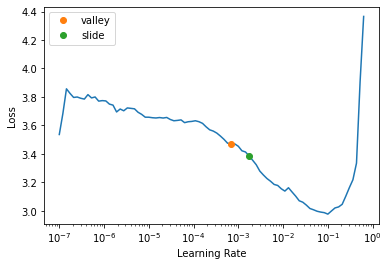

In [12]:
learn.lr_find(suggest_funcs=(valley, slide))

In [13]:
learn.fine_tune(10, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.782367,1.218258,0.398464,02:04


epoch,train_loss,valid_loss,error_rate,time
0,1.087299,0.713541,0.242919,02:05
1,0.895466,0.604205,0.191551,02:04
2,0.740593,0.510288,0.150264,02:05
3,0.543199,0.400270,0.122420,02:03
4,0.431764,0.297540,0.092175,02:02
5,0.302684,0.270911,0.080173,02:03
6,0.230135,0.245789,0.072972,02:02
7,0.183351,0.216141,0.063370,02:04
8,0.161343,0.211507,0.064810,02:00
9,0.160028,0.212707,0.061450,02:04


## It seems that the accuracy looks fine, but take too much time. How to improve it?

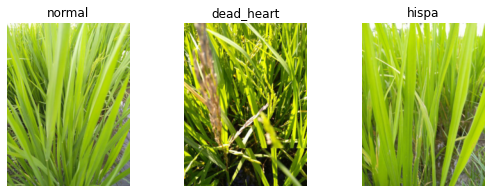

In [14]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize((256,192))) #This will give us 192x256px images.

dls.show_batch(max_n=3)

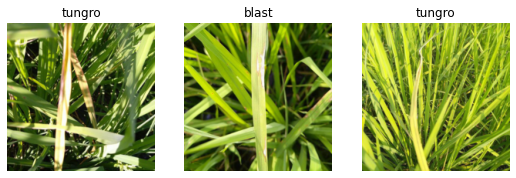

In [17]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(192)) 

dls.show_batch(max_n=3)

# Put the modeling steps together into a little function which we can pass the architecture, item transforms, and batch transforms to:

In [15]:
def train(arch, item, batch, epochs=5):
    dls = ImageDataLoaders.from_folder(trn_path, seed=42, valid_pct=0.2, item_tfms=item, batch_tfms=batch)
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
    learn.fine_tune(epochs, 0.01)
    return learn

In [16]:
learn = train('resnet26d', item=Resize(192),
              batch=aug_transforms(size=128, min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.900729,1.545458,0.484878,01:42


epoch,train_loss,valid_loss,error_rate,time
0,1.242679,1.042626,0.354777,01:45
1,0.979545,0.679328,0.215554,01:45
2,0.684938,0.490279,0.152664,01:45
3,0.492000,0.373366,0.116179,01:44
4,0.403524,0.361178,0.110418,01:48


### We can noticed that after we made the size of image smaller, the speed would increase.

### ConvNeXt model

In [18]:
arch = 'convnext_small_in22k'

In [19]:
learn = train(arch, item=Resize(192, method='squish'),
              batch=aug_transforms(size=128, min_scale=0.75))

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.256281,0.731169,0.222756,02:00


epoch,train_loss,valid_loss,error_rate,time
0,0.626983,0.446218,0.138262,01:59
1,0.487702,0.306864,0.097456,02:01
2,0.310722,0.236564,0.068651,02:01
3,0.183115,0.164828,0.047048,02:01
4,0.117052,0.149485,0.045127,02:02


### We can notice that the error rate reduced by more than half.

### We can also try padding, which keeps all the priginal image without transformin it.

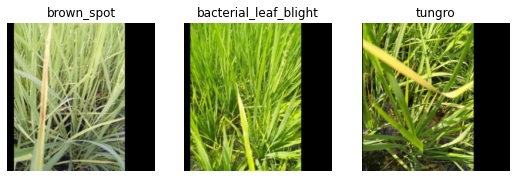

In [20]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(192, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros))
dls.show_batch(max_n=3)

In [21]:
learn = train(arch, item=Resize((256,192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
      batch=aug_transforms(size=(171,128), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.256264,0.708508,0.228997,01:57


epoch,train_loss,valid_loss,error_rate,time
0,0.632100,0.448244,0.132501,01:56
1,0.500714,0.349027,0.103697,01:57
2,0.322679,0.193535,0.061450,01:56
3,0.200937,0.147910,0.043207,01:57
4,0.148218,0.144204,0.039846,01:56


### The result is better!

In [22]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)

In [23]:
error_rate(preds, targs)

TensorBase(0.0398)

### Try test time augmentation (TTA)
To make the predictions even better, we can try test time augmentation (TTA), which our book defines as:

During inference or validation, creating multiple versions of each image, using data augmentation, and then taking the average or maximum of the predictions for each augmented version of the image.

In [24]:
tta_preds,_ = learn.tta(dl=valid)

In [25]:
error_rate(tta_preds, targs)

TensorBase(0.0326)

## Better result!